In [33]:
# @title Load packages and download model weights
from huggingface_hub import hf_hub_download
import torch, open_clip
from PIL import Image
from IPython.display import display

# for model_name in ['RN50'] #, 'ViT-B-32', 'ViT-L-14']: #faster loading
for model_name in ['RN50', 'ViT-B-32', 'ViT-L-14']: #all models
    checkpoint_path = hf_hub_download("chendelong/RemoteCLIP", f"RemoteCLIP-{model_name}.pt", cache_dir='checkpoints')
    print(f'{model_name} is downloaded to {checkpoint_path}.')

RN50 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-RN50.pt.
ViT-B-32 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-B-32.pt.
ViT-L-14 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-L-14.pt.


In [34]:
# @title Select Model
model_name = 'ViT-L-14' # @param ['RN50', 'ViT-B-32', 'ViT-L-14']
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

path_to_your_checkpoints = 'checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38'

ckpt = torch.load(f"{path_to_your_checkpoints}/RemoteCLIP-{model_name}.pt", map_location="cuda")
message = model.load_state_dict(ckpt)
print(message)
model = model.cuda().eval()

<All keys matched successfully>


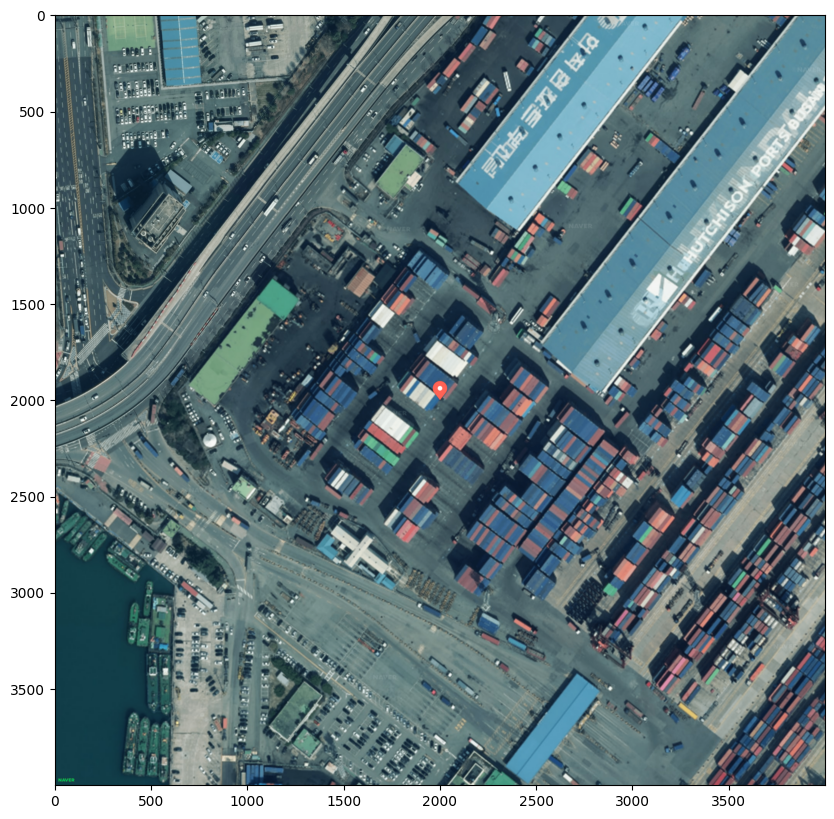

In [35]:
# @title Text caption queries
text_queries = [
"The 63 Building is in the center of the photo, surrounded by several high-rise buildings. Additionally, there are roads converging into a highway nearby.",
"The 63 Building is in the center of the photo and (it is covered by clouds), surrounded by several high-rise buildings. Additionally, there are roads converging into a highway nearby.",
"The Lotte World Tower is in the center of the photo, surrounded by a wide intersection with a high volume of traffic.",
"The Lotte World Tower is in the center of the photo and (it is covered by clouds), surrounded by a wide intersection with a high volume of traffic.",
"There is a palace with an antique atmosphere. This place is in Korea, and it seems the photo was taken there.",
"A bridge is visible over the river, and there is an island next to the bridge.",
"An airport is visible with many airplanes.",
"A port with some ships. there is blue ocean",
"A port with some ships. there is blue ocean and (it is covered by clouds)"
]
text = tokenizer(text_queries)
image = Image.open("/root/Geo_Cloud/Demo_images/129.0572263_35.1263757.png").convert('RGB') #convert to rgb allows it to display as png if the jpg is in cmyk

import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
plt.imshow(image)

In [36]:
# @title Predicted probabilities
image = preprocess(image).unsqueeze(0)

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image.cuda())
    text_features = model.encode_text(text.cuda())
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]

print(f'Predictions of {model_name}:')
for query, prob in zip(text_queries, text_probs):
    print(f"{query:<40} {prob * 100:5.1f}%")

Predictions of ViT-L-14:
The 63 Building is in the center of the photo, surrounded by several high-rise buildings. Additionally, there are roads converging into a highway nearby.   1.2%
The 63 Building is in the center of the photo and (it is covered by clouds), surrounded by several high-rise buildings. Additionally, there are roads converging into a highway nearby.   0.1%
The Lotte World Tower is in the center of the photo, surrounded by a wide intersection with a high volume of traffic.   0.3%
The Lotte World Tower is in the center of the photo and (it is covered by clouds), surrounded by a wide intersection with a high volume of traffic.   0.0%
There is a palace with an antique atmosphere. This place is in Korea, and it seems the photo was taken there.   2.0%
A bridge is visible over the river, and there is an island next to the bridge.   0.3%
An airport is visible with many airplanes.   0.3%
A port with some ships. there is blue ocean  86.0%
A port with some ships. there is blue o